In [217]:
import requests
import time
import json
from IPython.display import JSON

Obtain `issn_l` from OpenAlex for Open Access journals

In [218]:
f=open('/scratch/restrepo/oa.json','r')
va=json.load(f)
f.close()

In [219]:
issns=[d.get('issn_l') for d in va]

In [220]:
len(issns)

16819

Load DOAJ journal full json database

In [224]:
f=open('/scratch/restrepo/doaj.json','r')
doaj=json.load(f)
f.close()

In [222]:
ls -lh /scratch/restrepo/doaj.json

-rw-r--r-- 1 restrepo restrepo 43M Oct 31  2023 /scratch/restrepo/doaj.json


Build backend for DOAJ

In [235]:
issn='0367-8318'

In [223]:
DOAJ={}
i=0
for issn in issns:
    loa=[d['bibjson'] for d in doaj if d['bibjson'].get('eissn')==issn or d['bibjson'].get('pissn')==issn]
    print(str(i).zfill(5),end='\r')
    i+=1
    if not loa:
        continue
    
    d=loa[0]
    
    try:
        doi = 'DOI' in d.get('pid_scheme').get('scheme')
    except:
        doi = False
    try:
        license = d.get('license')[0].get('type')
    except:
        license = None


    DOAJ[issn] = {'issn_l':issn,
        'publication_time_weeks': d.get('publication_time_weeks'),
     'oa_start': d.get( 'oa_start'),
     'copyright.author_retains': d.get('copyright').get('author_retains'),
     'editorial.review_process': d.get('editorial').get('review_process'),
     'other_charges.has_other_charges': d.get('other_charges').get('has_other_charges'),
     'pid_scheme.DOI': doi,
     'plagiarism.detection': d.get('plagiarism').get('detection'),
     'waiver.has_waiver': d.get('waiver').get('has_waiver'),
     'keywords': d.get('keywords'),
     'language': d.get('language'),
     'license.type': license,
     'subject.term': [ x.get('term')  for x in d.get('subject')][::-1]
    }        

In [240]:
len(DOAJ.keys())

15692

In [226]:
f=open('DOAJ.json','w')
json.dump(DOAJ,f)
f.close()

In [227]:
ls -lh DOAJ.json

-rw-r--r-- 1 restrepo restrepo 7.6M Oct 31  2023 DOAJ.json


In [217]:
import requests
import time
import json
from IPython.display import JSON

In [113]:
va=[]
i=0
count=0
baseurl='https://api.openalex.org/sources?filter=is_in_doaj:true&mailto=restrepo@udea.edu.co&per-page=200'
nc='*'

In [114]:
while nc:
    i+=1
    url=baseurl+f'&cursor={nc}'
    r=requests.get(url)
    cotmp=r.json().get('results')

    if i==1:
        count=r.json().get('meta').get('count')
    nc=r.json().get('meta').get('next_cursor')
    #progress
    print(f'{i} → {200*i}/{count}',end='\r')
    #Append to dictionary list (WARNING: HIG RAM USAGE)
    for p in cotmp:
        va.append(p)
    #API limits
    time.sleep(0.1)
    #EMERGENGY EXIT
    if i*200>count:
        break

In [122]:
len(va)

16819

In [123]:
[d for d in va if d.get('issn_l')=='2688-8130']

[]

In [115]:
f=open('/scratch/restrepo/oa.json','w')
json.dump(va,f)
f.close()

In [106]:
f=open('/scratch/restrepo/oa.json','r')
va=json.load(f)
f.close()

In [116]:
issns=[d.get('issn_l') for d in va]

In [117]:
len(issns)

16819

In [230]:
test=['2688-8130','0367-8318','0019-5022','0006-3134',
     '1005-3409','1868-9892','1355-557X','1611-2156']
set(test).difference(issns)

{'2688-8130'}

In [238]:
[k for k in test if k in DOAJ.keys()] 

['0367-8318', '0019-5022', '1005-3409', '1868-9892', '1355-557X', '1611-2156']

In [239]:
len(set(DOAJ.keys()))

15692

Analysis

In [139]:
df=pd.DataFrame(va)

In [204]:
df['h_index']=df.summary_stats.str.get('h_index')

In [141]:
df.columns

Index(['id', 'issn_l', 'issn', 'display_name', 'host_organization',
       'host_organization_name', 'host_organization_lineage', 'works_count',
       'cited_by_count', 'summary_stats', 'is_oa', 'is_in_doaj', 'ids',
       'homepage_url', 'apc_prices', 'apc_usd', 'country_code', 'societies',
       'alternate_titles', 'abbreviated_title', 'type', 'x_concepts',
       'counts_by_year', 'works_api_url', 'updated_date', 'created_date'],
      dtype='object')

In [144]:
%matplotlib inline

0        456
1        724
2        313
3        229
4        597
        ... 
16814      3
16815      1
16816      0
16817      1
16818      2
Name: summary_stats, Length: 16819, dtype: int64

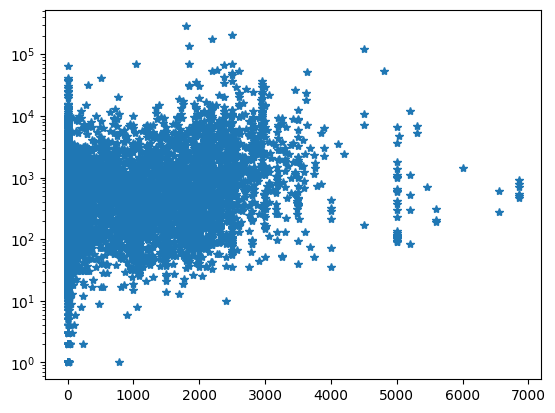

In [149]:
plt.semilogy(df.apc_usd,df['works_count'],'*')

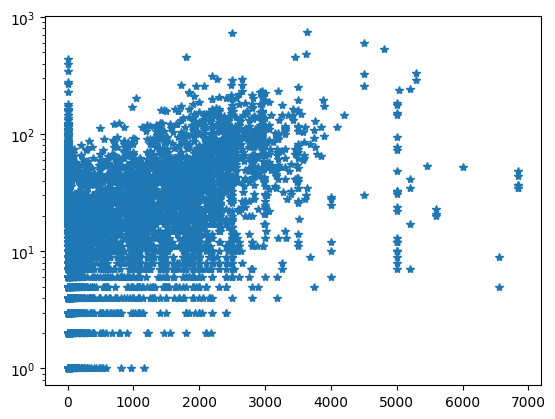

In [159]:
plt.semilogy(df.apc_usd,df.summary_stats.str.get('h_index'),'*')

In [177]:
df.shape

(16819, 26)

In [279]:
dff=df[ (df.cited_by_count>0) & (df.summary_stats.str.get('h_index')>0)]
dff.shape

(16473, 28)

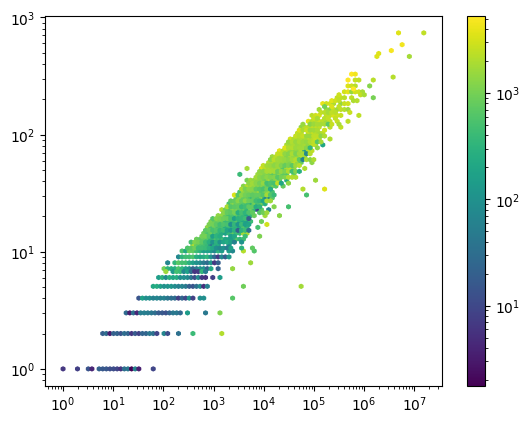

In [280]:
#plt.plot(df.cited_by_count,df.summary_stats.str.get('h_index'),'.')#,df.apc_usd)
plt.hexbin(dff.cited_by_count,dff.summary_stats.str.get('h_index'),
           dff.apc_usd,bins='log',xscale='log',yscale='log')

plt.colorbar()
#plt.xscale('log')
#plt.yscale('log')
#plt.bi
#plt.xlim(0,1E6)

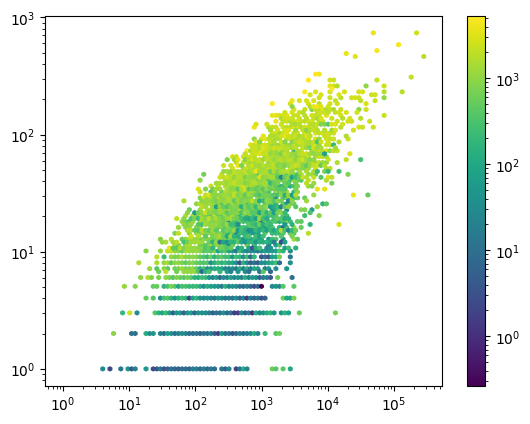

In [281]:
#plt.plot(df.cited_by_count,df.summary_stats.str.get('h_index'),'.')#,df.apc_usd)
plt.hexbin(dff.works_count,dff.summary_stats.str.get('h_index'),
           dff.apc_usd,bins='log',xscale='log',yscale='log')

plt.colorbar()
#plt.xscale('log')
#plt.yscale('log')
#plt.bi
#plt.xlim(0,1E6)

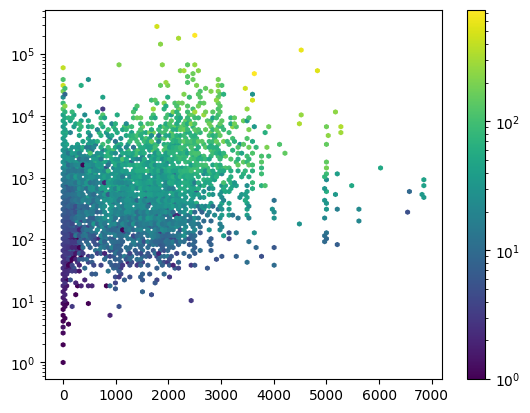

In [282]:
plt.hexbin(dff.apc_usd,dff.works_count, dff.summary_stats.str.get('h_index'),
           bins='log',yscale='log')

plt.colorbar()

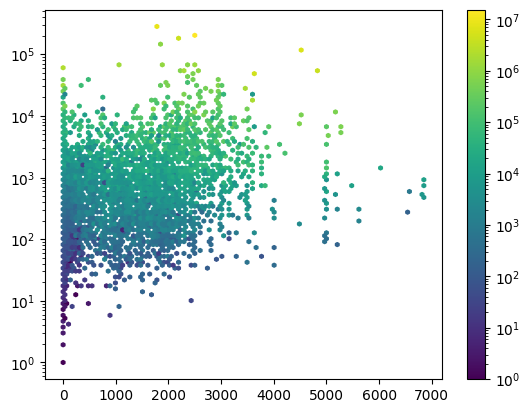

In [283]:
plt.hexbin(dff.apc_usd,dff.works_count, dff.cited_by_count,
           bins='log',yscale='log')

plt.colorbar()

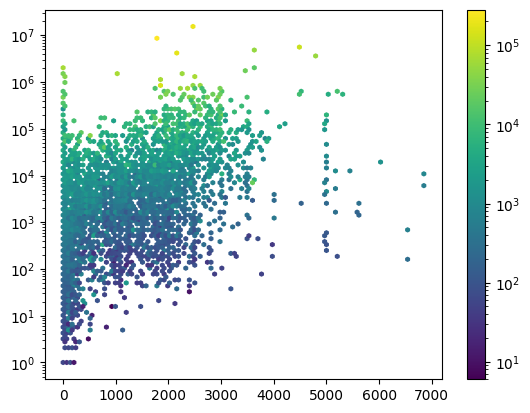

In [284]:
plt.hexbin(dff.apc_usd,dff.cited_by_count, dff.works_count, 
           bins='log',yscale='log')

plt.colorbar()

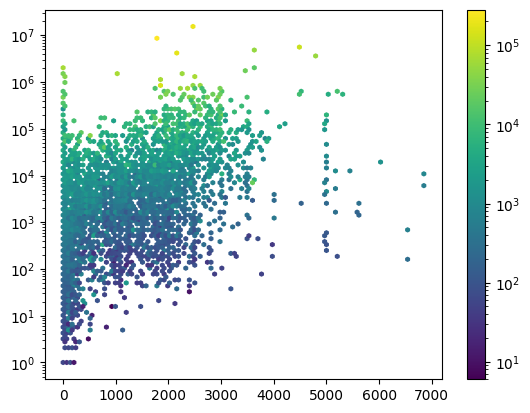

In [285]:
plt.hexbin(dff.apc_usd,dff.cited_by_count, dff.works_count, 
           bins='log',yscale='log')

plt.colorbar()

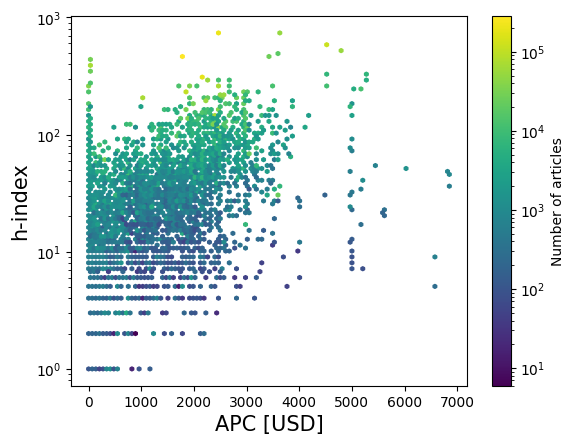

In [286]:
plt.hexbin(dff.apc_usd,dff.summary_stats.str.get('h_index'), dff.works_count, 
           bins='log',yscale='log')

plt.colorbar(label='Number of articles')
plt.xlabel('APC [USD]',size=15)
plt.ylabel('h-index',size=15)
plt.savefig('apc.png')

In [264]:
def get_main_concept(L):
    for d in L:
        if d.get('level')==0:
            return f"0:{d.get('display_name')}"
    for d in L:
        if d.get('level')==1:
            return f"1:{d.get('display_name')}"
    for d in L:
        if d.get('level')==2:
            return f"2:{d.get('display_name')}"
    for d in L:
        if d.get('level')==3:
            return f"3:{d.get('display_name')}"
    for d in L:
        if d.get('level')==4:
            return f"4:{d.get('display_name')}"
    for d in L:
        if d.get('level')==5:
            return f"5:{d.get('display_name')}"
    for d in L:
        if d.get('level')==6:
            return f"6:{d.get('display_name')}"
    return None
        

In [266]:
df['concept']=df.x_concepts.apply(get_main_concept)

In [273]:
df.concept.shape

(16819,)

In [274]:
df.concept.dropna().shape

(16538,)

In [303]:
concepts=df.concept.unique()
concepts=[c for c in concepts if c]
concepts

['0:Biology',
 '0:Chemistry',
 '0:Medicine',
 '0:Physics',
 '0:Computer science',
 '0:Engineering',
 '0:Materials science',
 '0:Psychology',
 '0:Geography',
 '0:Mathematics',
 '0:Political science',
 '0:Geology',
 '0:Art',
 '0:Philosophy',
 '0:Sociology',
 '0:Environmental science',
 '0:Economics',
 '0:History',
 '0:Business']

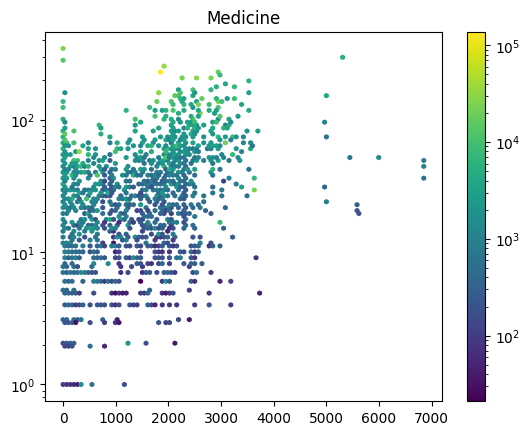

In [292]:
i=2
dff=df[df.concept == concepts[i]]
dff=dff[ (dff.cited_by_count>0) & (dff.summary_stats.str.get('h_index')>0)]
plt.title(concepts[i].split(':')[-1])
plt.hexbin(dff.apc_usd,dff.summary_stats.str.get('h_index'), dff.works_count, 
           bins='log',yscale='log')
plt.colorbar()

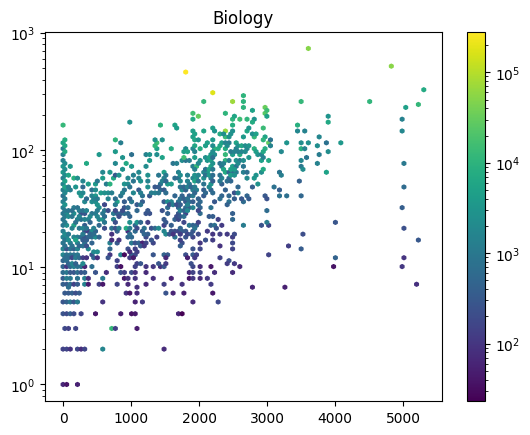

In [293]:
i=0
dff=df[df.concept == concepts[i]]
dff=dff[ (dff.cited_by_count>0) & (dff.summary_stats.str.get('h_index')>0)]
plt.title(concepts[i].split(':')[-1])
plt.hexbin(dff.apc_usd,dff.summary_stats.str.get('h_index'), dff.works_count, 
           bins='log',yscale='log')
plt.colorbar()

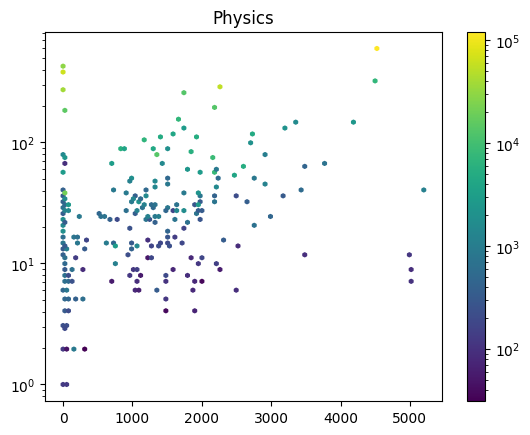

In [294]:
i=3
dff=df[df.concept == concepts[i]]
dff=dff[ (dff.cited_by_count>0) & (dff.summary_stats.str.get('h_index')>0)]
plt.title(concepts[i].split(':')[-1])
plt.hexbin(dff.apc_usd,dff.summary_stats.str.get('h_index'), dff.works_count, 
           bins='log',yscale='log')
plt.colorbar()

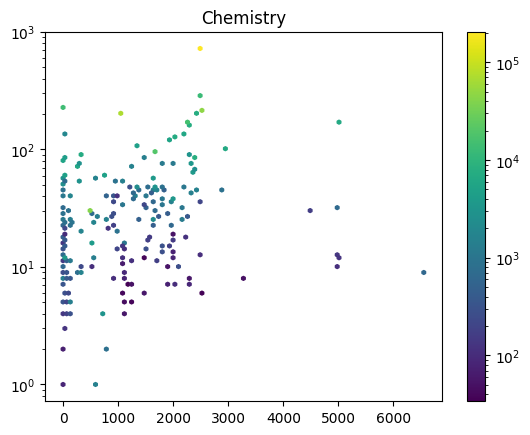

In [290]:
i=1
dff=df[df.concept == concepts[i]]
dff=dff[ (dff.cited_by_count>0) & (dff.summary_stats.str.get('h_index')>0)]
plt.title(concepts[i].split(':')[-1])
plt.hexbin(dff.apc_usd,dff.summary_stats.str.get('h_index'), dff.works_count, 
           bins='log',yscale='log')
plt.colorbar()

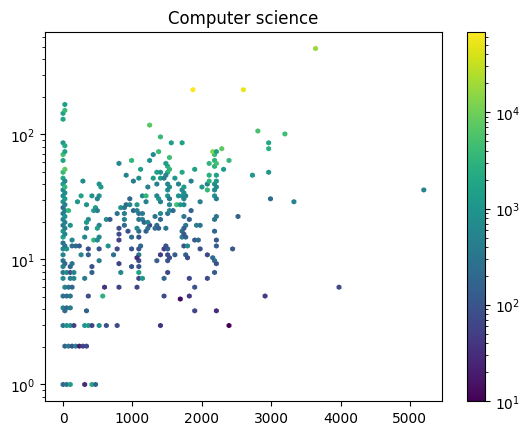

In [295]:
i=4
dff=df[df.concept == concepts[i]]
dff=dff[ (dff.cited_by_count>0) & (dff.summary_stats.str.get('h_index')>0)]
plt.title(concepts[i].split(':')[-1])
plt.hexbin(dff.apc_usd,dff.summary_stats.str.get('h_index'), dff.works_count, 
           bins='log',yscale='log')
plt.colorbar()

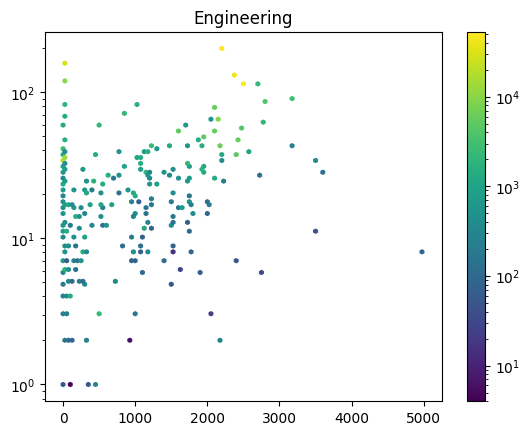

In [297]:
i=5
dff=df[df.concept == concepts[i]]
dff=dff[ (dff.cited_by_count>0) & (dff.summary_stats.str.get('h_index')>0)]
plt.title(concepts[i].split(':')[-1])
plt.hexbin(dff.apc_usd,dff.summary_stats.str.get('h_index'), dff.works_count, 
           bins='log',yscale='log')
plt.colorbar()

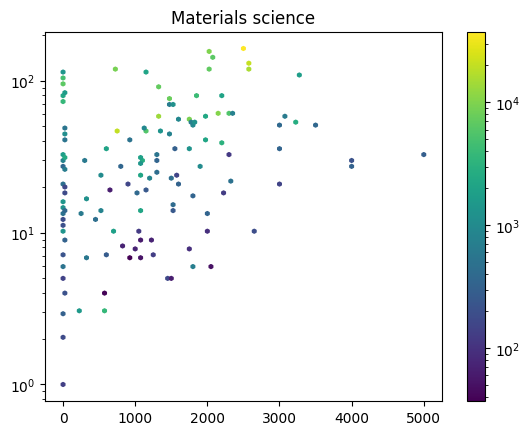

In [298]:
i=6
dff=df[df.concept == concepts[i]]
dff=dff[ (dff.cited_by_count>0) & (dff.summary_stats.str.get('h_index')>0)]
plt.title(concepts[i].split(':')[-1])
plt.hexbin(dff.apc_usd,dff.summary_stats.str.get('h_index'), dff.works_count, 
           bins='log',yscale='log')
plt.colorbar()

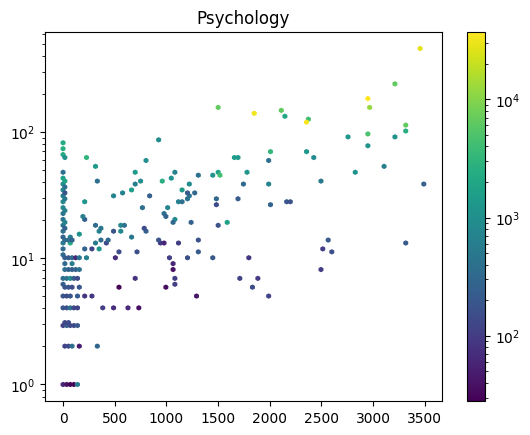

In [299]:
i=7
dff=df[df.concept == concepts[i]]
dff=dff[ (dff.cited_by_count>0) & (dff.summary_stats.str.get('h_index')>0)]
plt.title(concepts[i].split(':')[-1])
plt.hexbin(dff.apc_usd,dff.summary_stats.str.get('h_index'), dff.works_count, 
           bins='log',yscale='log')
plt.colorbar()

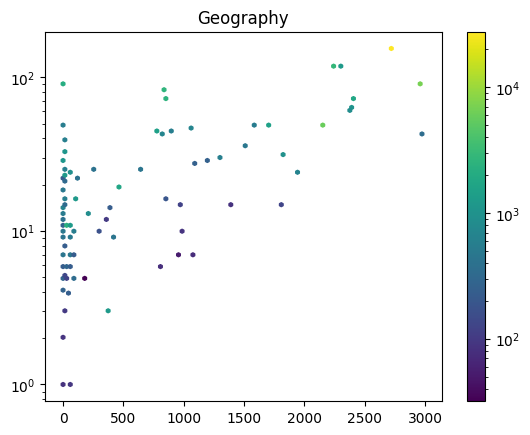

In [300]:
i=8
dff=df[df.concept == concepts[i]]
dff=dff[ (dff.cited_by_count>0) & (dff.summary_stats.str.get('h_index')>0)]
plt.title(concepts[i].split(':')[-1])
plt.hexbin(dff.apc_usd,dff.summary_stats.str.get('h_index'), dff.works_count, 
           bins='log',yscale='log')
plt.colorbar()

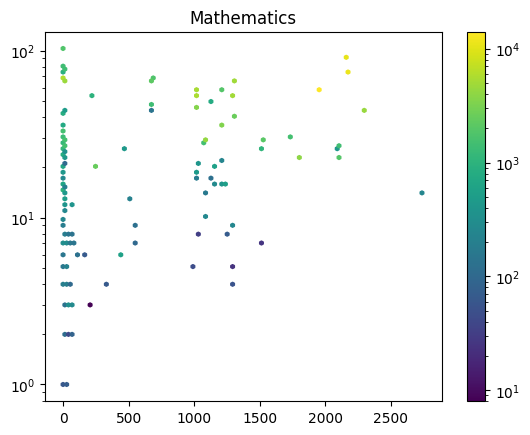

In [301]:
i=9
dff=df[df.concept == concepts[i]]
dff=dff[ (dff.cited_by_count>0) & (dff.summary_stats.str.get('h_index')>0)]
plt.title(concepts[i].split(':')[-1])
plt.hexbin(dff.apc_usd,dff.summary_stats.str.get('h_index'), dff.works_count, 
           bins='log',yscale='log')
plt.colorbar()

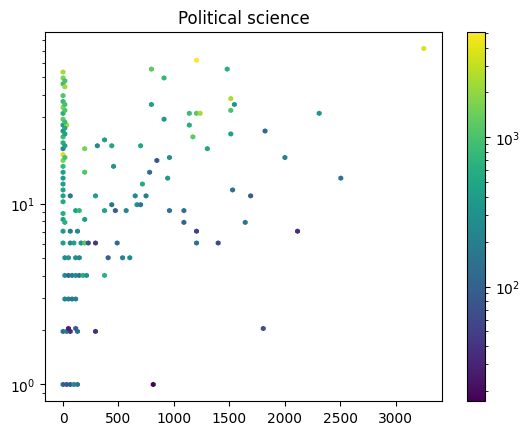

In [304]:
i=10
dff=df[df.concept == concepts[i]]
dff=dff[ (dff.cited_by_count>0) & (dff.summary_stats.str.get('h_index')>0)]
plt.title(concepts[i].split(':')[-1])
plt.hexbin(dff.apc_usd,dff.summary_stats.str.get('h_index'), dff.works_count, 
           bins='log',yscale='log')
plt.colorbar()

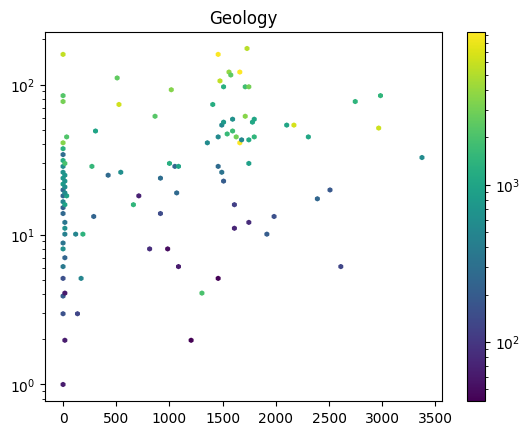

In [305]:
i=11
dff=df[df.concept == concepts[i]]
dff=dff[ (dff.cited_by_count>0) & (dff.summary_stats.str.get('h_index')>0)]
plt.title(concepts[i].split(':')[-1])
plt.hexbin(dff.apc_usd,dff.summary_stats.str.get('h_index'), dff.works_count, 
           bins='log',yscale='log')
plt.colorbar()

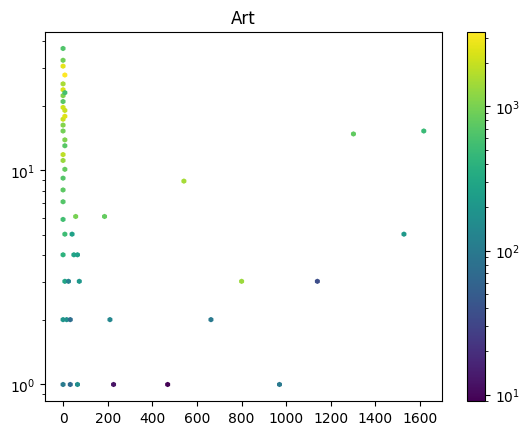

In [306]:
i=12
dff=df[df.concept == concepts[i]]
dff=dff[ (dff.cited_by_count>0) & (dff.summary_stats.str.get('h_index')>0)]
plt.title(concepts[i].split(':')[-1])
plt.hexbin(dff.apc_usd,dff.summary_stats.str.get('h_index'), dff.works_count, 
           bins='log',yscale='log')
plt.colorbar()

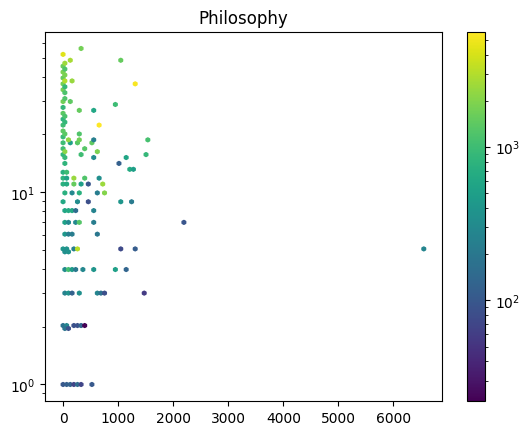

In [307]:
i=13
dff=df[df.concept == concepts[i]]
dff=dff[ (dff.cited_by_count>0) & (dff.summary_stats.str.get('h_index')>0)]
plt.title(concepts[i].split(':')[-1])
plt.hexbin(dff.apc_usd,dff.summary_stats.str.get('h_index'), dff.works_count, 
           bins='log',yscale='log')
plt.colorbar()

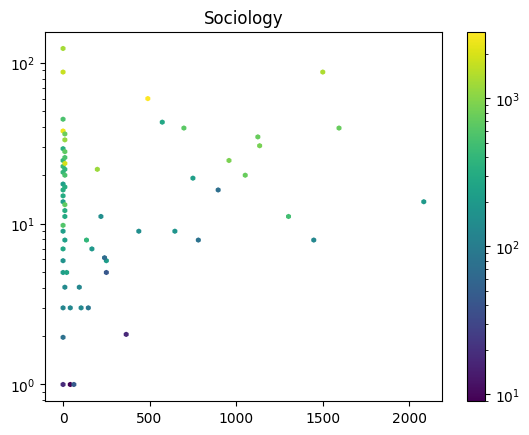

In [308]:
i=14
dff=df[df.concept == concepts[i]]
dff=dff[ (dff.cited_by_count>0) & (dff.summary_stats.str.get('h_index')>0)]
plt.title(concepts[i].split(':')[-1])
plt.hexbin(dff.apc_usd,dff.summary_stats.str.get('h_index'), dff.works_count, 
           bins='log',yscale='log')
plt.colorbar()

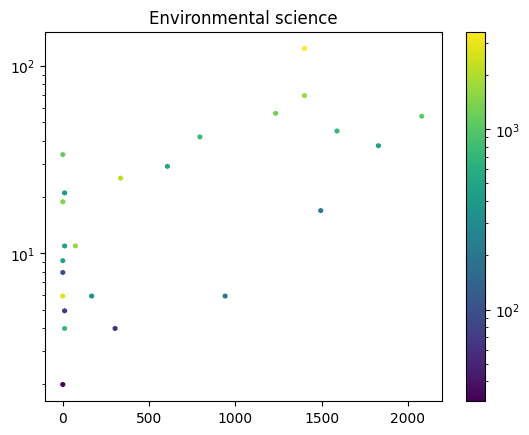

In [309]:
i=15
dff=df[df.concept == concepts[i]]
dff=dff[ (dff.cited_by_count>0) & (dff.summary_stats.str.get('h_index')>0)]
plt.title(concepts[i].split(':')[-1])
plt.hexbin(dff.apc_usd,dff.summary_stats.str.get('h_index'), dff.works_count, 
           bins='log',yscale='log')
plt.colorbar()

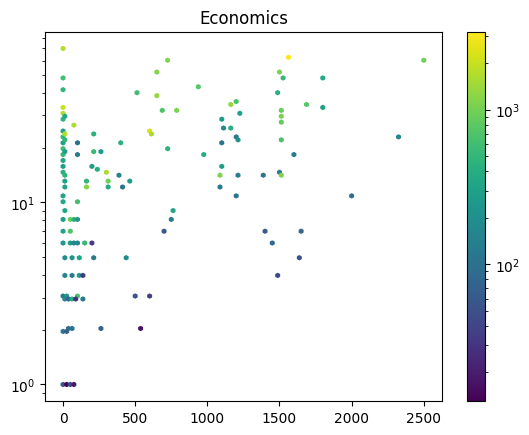

In [310]:
i=16
dff=df[df.concept == concepts[i]]
dff=dff[ (dff.cited_by_count>0) & (dff.summary_stats.str.get('h_index')>0)]
plt.title(concepts[i].split(':')[-1])
plt.hexbin(dff.apc_usd,dff.summary_stats.str.get('h_index'), dff.works_count, 
           bins='log',yscale='log')
plt.colorbar()

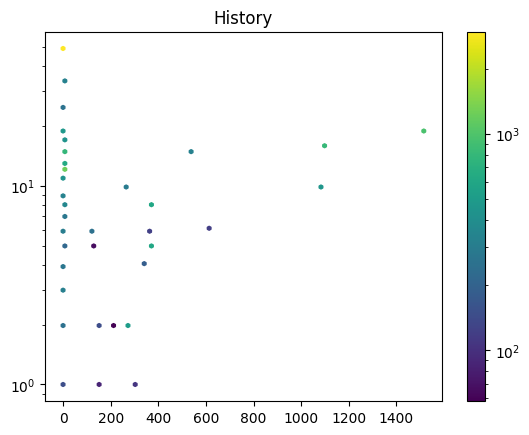

In [311]:
i=17
dff=df[df.concept == concepts[i]]
dff=dff[ (dff.cited_by_count>0) & (dff.summary_stats.str.get('h_index')>0)]
plt.title(concepts[i].split(':')[-1])
plt.hexbin(dff.apc_usd,dff.summary_stats.str.get('h_index'), dff.works_count, 
           bins='log',yscale='log')
plt.colorbar()

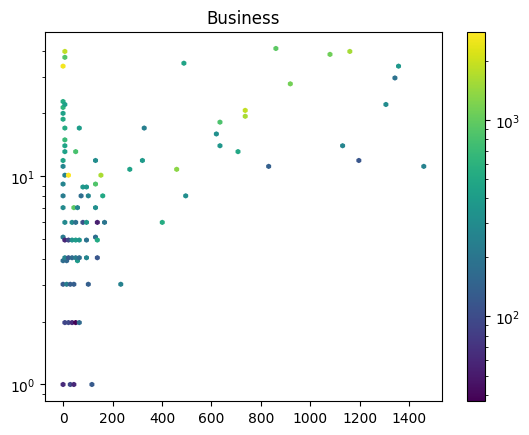

In [312]:
i=18
dff=df[df.concept == concepts[i]]
dff=dff[ (dff.cited_by_count>0) & (dff.summary_stats.str.get('h_index')>0)]
plt.title(concepts[i].split(':')[-1])
plt.hexbin(dff.apc_usd,dff.summary_stats.str.get('h_index'), dff.works_count, 
           bins='log',yscale='log')
plt.colorbar()

In [296]:
df[(df.apc_usd==0) & (df.h_index>1E2)].sort_values('h_index',ascending=False)

,id,issn_l,issn,display_name,host_organization,host_organization_name,host_organization_lineage,works_count,cited_by_count,summary_stats,...,alternate_titles,abbreviated_title,type,x_concepts,counts_by_year,works_api_url,updated_date,created_date,h_index,concept
31,https://openalex.org/S4210194812,0550-3213,"[1873-1562, 0550-3213]",Nuclear Physics B,https://openalex.org/P4310320990,Elsevier BV,[https://openalex.org/P4310320990],30167,1442726,"{'2yr_mean_citedness': 2.78544776119403, 'h_in...",...,[],None,journal,"[{'id': 'https://openalex.org/C121332964', 'wi...","[{'year': 2023, 'works_count': 277, 'cited_by_...",https://api.openalex.org/works?filter=primary_...,2023-10-30T15:22:17.428891,2022-02-03,434,0:Physics
9,https://openalex.org/S173952182,0370-2693,"[0370-2693, 1873-2445]",Physics Letters B,https://openalex.org/P4310320990,Elsevier BV,[https://openalex.org/P4310320990],64913,2108892,"{'2yr_mean_citedness': 4.228044280442805, 'h_i...",...,[Nuclear physics],None,journal,"[{'id': 'https://openalex.org/C121332964', 'wi...","[{'year': 2023, 'works_count': 661, 'cited_by_...",https://api.openalex.org/works?filter=primary_...,2023-10-30T23:01:10.467767,2016-06-24,393,0:Physics
39,https://openalex.org/S10446503,0091-6765,"[0091-6765, 1552-9924]",Environmental Health Perspectives,https://openalex.org/P4310319799,National Institute of Environmental Health Sci...,"[https://openalex.org/P4310316754, https://ope...",25353,954263,"{'2yr_mean_citedness': 6.990762124711316, 'h_i...",...,"[EHP online, EHP]",None,journal,"[{'id': 'https://openalex.org/C71924100', 'wik...","[{'year': 2023, 'works_count': 237, 'cited_by_...",https://api.openalex.org/works?filter=primary_...,2023-10-30T23:23:30.814638,2016-06-24,345,0:Medicine
84,https://openalex.org/S189281586,1080-6040,"[1080-6059, 1080-6040]",Emerging Infectious Diseases,https://openalex.org/P4310315581,Centers for Disease Control and Prevention,[https://openalex.org/P4310315581],13539,651002,"{'2yr_mean_citedness': 8.696400625978091, 'h_i...",...,[EID],None,journal,"[{'id': 'https://openalex.org/C71924100', 'wik...","[{'year': 2109, 'works_count': 0, 'cited_by_co...",https://api.openalex.org/works?filter=primary_...,2023-10-31T01:58:09.880329,2016-06-24,277,0:Medicine
20,https://openalex.org/S187585107,1029-8479,"[1127-2236, 1126-6708, 1029-8479]",Journal of High Energy Physics,https://openalex.org/P4310319965,Springer Nature,[https://openalex.org/P4310319965],38264,1318974,"{'2yr_mean_citedness': 4.30891785640389, 'h_in...",...,"[Paper archive, Journal of high energy physics...",None,journal,"[{'id': 'https://openalex.org/C121332964', 'wi...","[{'year': 2023, 'works_count': 2112, 'cited_by...",https://api.openalex.org/works?filter=primary_...,2023-10-31T01:47:22.318955,2016-06-24,268,0:Physics
81,https://openalex.org/S184645833,2041-6520,"[2041-6520, 2041-6539]",Chemical Science,https://openalex.org/P4310320556,Royal Society of Chemistry,[https://openalex.org/P4310320556],14006,546232,"{'2yr_mean_citedness': 7.554689674366824, 'h_i...",...,[],None,journal,"[{'id': 'https://openalex.org/C185592680', 'wi...","[{'year': 2023, 'works_count': 1468, 'cited_by...",https://api.openalex.org/works?filter=primary_...,2023-10-30T20:30:35.786064,2016-06-24,227,0:Chemistry
69,https://openalex.org/S94052278,1434-6044,"[1434-6044, 1434-6052]",The European Physical Journal C,https://openalex.org/P4310319900,Springer Science+Business Media,"[https://openalex.org/P4310319900, https://ope...",15352,351838,"{'2yr_mean_citedness': 3.8153266331658293, 'h_...",...,"[EPJ C, The European physical journal, The Eur...",None,journal,"[{'id': 'https://openalex.org/C121332964', 'wi...","[{'year': 2023, 'works_count': 968, 'cited_by_...",https://api.openalex.org/works?filter=primary_...,2023-10-31T00:56:38.678069,2016-06-24,181,0:Physics
1499,https://openalex.org/S167961193,1548-7660,[1548-7660],Journal of Statistical Software,https://openalex.org/P4310315759,Foundation for Open Access Statistics,[https://openalex.

In [208]:
df[(df.apc_usd>1500) & (df.h_index>4E2)].sort_values('h_index',ascending=False)

,id,issn_l,issn,display_name,host_organization,host_organization_name,host_organization_lineage,works_count,cited_by_count,summary_stats,...,societies,alternate_titles,abbreviated_title,type,x_concepts,counts_by_year,works_api_url,updated_date,created_date,h_index
14,https://openalex.org/S134668137,0305-1048,"[1362-4962, 1362-4954, 0305-1048]",Nucleic Acids Research,https://openalex.org/P4310311648,Oxford University Press,"[https://openalex.org/P4310311647, https://ope...",51422,4563630,"{'2yr_mean_citedness': 16.116385911179172, 'h_...",...,[],[NAR online],None,journal,"[{'id': 'https://openalex.org/C86803240', 'wik...","[{'year': 2023, 'works_count': 989, 'cited_by_...",https://api.openalex.org/works?filter=primary_...,2023-10-30T23:59:06.483496,2016-06-24,737
1,https://openalex.org/S140251998,0021-9258,"[1083-351X, 0021-9258, 1067-8816]",Journal of Biological Chemistry,https://openalex.org/P4310320990,Elsevier BV,[https://openalex.org/P4310320990],205956,15488895,"{'2yr_mean_citedness': 4.773095623987034, 'h_i...",...,"[{'url': 'https://www.asbmb.org/', 'organizati...","[JBC, JBC online]",None,journal,"[{'id': 'https://openalex.org/C185592680', 'wi...","[{'year': 2023, 'works_count': 2549, 'cited_by...",https://api.openalex.org/works?filter=primary_...,2023-10-30T22:40:51.457729,2016-06-24,724
4,https://openalex.org/S1980519,0004-637X,"[1538-4357, 0004-637X]",The Astrophysical Journal,https://openalex.org/P4310320083,IOP Publishing,"[https://openalex.org/P4310311669, https://ope...",121565,6023944,"{'2yr_mean_citedness': 4.207069913589945, 'h_i...",...,[],[ApJ],None,journal,"[{'id': 'https://openalex.org/C121332964', 'wi...","[{'year': 2023, 'works_count': 2408, 'cited_by...",https://api.openalex.org/works?filter=primary_...,2023-10-30T21:46:49.990299,2016-06-24,597
13,https://openalex.org/S64187185,2041-1723,[2041-1723],Nature Communications,https://openalex.org/P4310319908,Nature Portfolio,"[https://openalex.org/P4310319908, https://ope...",52873,3752788,"{'2yr_mean_citedness': 16.600864881268492, 'h_...",...,[],[],None,journal,"[{'id': 'https://openalex.org/C86803240', 'wik...","[{'year': 2023, 'works_count': 6846, 'cited_by...",https://api.openalex.org/works?filter=primary_...,2023-10-31T00:11:15.428488,2016-06-24,530
60,https://openalex.org/S52395412,1367-4803,"[1367-4811, 1367-4803]",Bioinformatics,https://openalex.org/P4310311648,Oxford University Press,"[https://openalex.org/P4310311647, https://ope...",18326,1948745,"{'2yr_mean_citedness': 5.493573264781491, 'h_i...",...,[],[Bioinformatics online],None,journal,"[{'id': 'https://openalex.org/C41008148', 'wik...","[{'year': 2023, 'works_count': 663, 'cited_by_...",https://api.openalex.org/works?filter=primary_...,2023-10-31T01:28:32.573017,2016-06-24,487
38,https://openalex.org/S103225281,1053-8119,"[1053-8119, 1095-9572]",NeuroImage,https://openalex.org/P4310320990,Elsevier BV,[https://openalex.org/P4310320990],26762,1796170,"{'2yr_mean_citedness': 6.6437747035573125, 'h_...",...,[],[Neuro image],None,journal,"[{'id': 'https://openalex.org/C15744967', 'wik...","[{'year': 2023, 'works_count': 579, 'cited_by_...",https://api.openalex.org/works?filter=primary_...,2023-10-30T16:13:32.798221,2016-06-24,458
0,https://openalex.org/S202381698,1932-6203,[1932-6203],PLOS ONE,https://openalex.org/P4310315706,Public Library of Science,[https://openalex.org/P4310315706],281808,8214195,"{'2yr_mean_citedness': 4.144535288036838, 'h_i...",...,[],"[PLoS ONE, Public Library of Science one, PLoS 1]",None,journal,"[{'id': 'https://openalex.org/C86803240', 'wik...","[{'year': 2023, 'works_count': 12218, 'cited_b...",https://api.openalex.org/works?filter=primary_...,2023-10-30T19:04:45.238144,2016-06-24,456


In [260]:
df[df.apc_usd>6800].x_concepts.str[0].str['display_name']

2766    Medicine
3242    Medicine
3680    Medicine
4773    Medicine
5146    Medicine
5452    Medicine
Name: x_concepts, dtype: object

In [261]:
df[df.apc_usd>6800].x_concepts.str[1].str['display_name']

2766              Biology
3242              Biology
3680        Ophthalmology
4773    Internal medicine
5146              Biology
5452              Biology
Name: x_concepts, dtype: object

In [262]:
df[df.apc_usd>6800].x_concepts.str[2].str['display_name']

2766          Dermatology
3242    Internal medicine
3680              Biology
4773              Biology
5146    Internal medicine
5452    Internal medicine
Name: x_concepts, dtype: object

In [263]:
df[df.apc_usd>6800].x_concepts.str[3].str['display_name']

2766    Internal medicine
3242             Genetics
3680              Surgery
4773            Pathology
5146           Psychology
5452           Psychology
Name: x_concepts, dtype: object